In [2]:
# Retry without ruptures for now (we'll handle structural break detection differently)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Load the dataset
file_path = "/content/unemployed_population_1978-12_to_2023-07.csv"
df = pd.read_csv(file_path)

# Parse the date and extract USA data
df['date'] = pd.to_datetime(df['date'])
ts = df.set_index('date')['all']

# Display basic info
ts.head(), ts.index.min(), ts.index.max()


(date
 2023-07-01    3.6
 2023-06-01    3.6
 2023-05-01    3.6
 2023-04-01    3.6
 2023-03-01    3.6
 Name: all, dtype: float64,
 Timestamp('1978-12-01 00:00:00'),
 Timestamp('2023-07-01 00:00:00'))

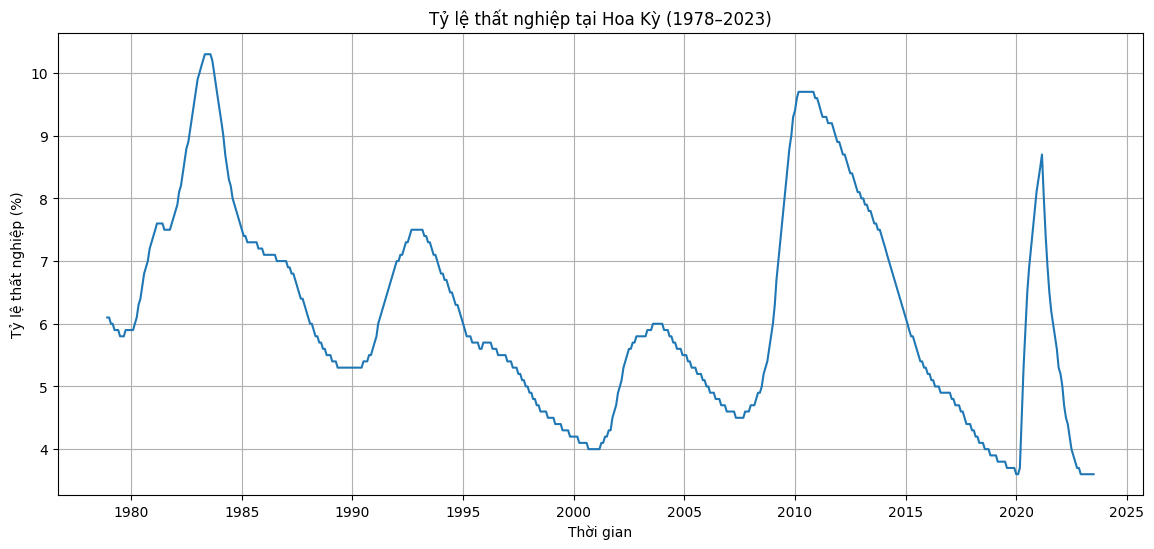

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/unemployed_population_1978-12_to_2023-07.csv")
df['date'] = pd.to_datetime(df['date'])
ts = df.set_index('date')['all']

plt.figure(figsize=(14, 6))
sns.lineplot(data=ts)
plt.title("Tỷ lệ thất nghiệp tại Hoa Kỳ (1978–2023)")
plt.xlabel("Thời gian")
plt.ylabel("Tỷ lệ thất nghiệp (%)")
plt.grid(True)
plt.show()


In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Chuỗi dừng.")
    else:
        print("Chuỗi không dừng.")

adf_test(ts)


ADF Statistic: -3.3605528110196756
p-value: 0.012379418170713228
Chuỗi dừng.


In [7]:
# ADF test function
def adf_test(series, title=''):
    print(f'>> Kết quả kiểm định ADF: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    for val, label in zip(result[:4], labels):
        print(f'{label}: {val}')
    if result[1] <= 0.05:
        print("=> Chuỗi **dừng** (có thể dùng cho ARIMA)")
    else:
        print("=> Chuỗi **không dừng** (cần lấy sai phân)")

# Thực hiện ADF test
adf_test(ts, "Tỷ lệ thất nghiệp gốc")


>> Kết quả kiểm định ADF: Tỷ lệ thất nghiệp gốc
ADF Statistic: -3.3605528110196756
p-value: 0.012379418170713228
# Lags Used: 15
Number of Observations Used: 520
=> Chuỗi **dừng** (có thể dùng cho ARIMA)


In [8]:
# Tạo biến giả: 0 nếu trước Mar-2020, 1 nếu từ Mar-2020 trở đi
df['policy_change'] = (df['date'] >= '2020-03-01').astype(int)

# Lấy sai phân bậc 1 để chuỗi dừng
df['diff_all'] = df['all'].diff()

# Loại bỏ giá trị NaN
df_model = df.dropna()


In [9]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Mô hình ARIMA thông thường (không xử lý structural break)
model_arima = ARIMA(df_model['all'], order=(1,1,1))
result_arima = model_arima.fit()

# Mô hình ARIMAX có thêm biến giả
model_arimax = ARIMA(df_model['all'], order=(1,1,1), exog=df_model[['policy_change']])
result_arimax = model_arimax.fit()


In [10]:
print("ARIMA Summary:")
print(result_arima.summary())

print("\nARIMAX Summary:")
print(result_arimax.summary())


ARIMA Summary:
                               SARIMAX Results                                
Dep. Variable:                    all   No. Observations:                  535
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 585.709
Date:                Tue, 03 Jun 2025   AIC                          -1165.419
Time:                        07:23:12   BIC                          -1152.577
Sample:                             0   HQIC                         -1160.394
                                - 535                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8937      0.011     78.893      0.000       0.872       0.916
ma.L1         -0.3363      0.023    -14.358      0.000      -0.382      -0.290
sigma2         0.0065      0.000     

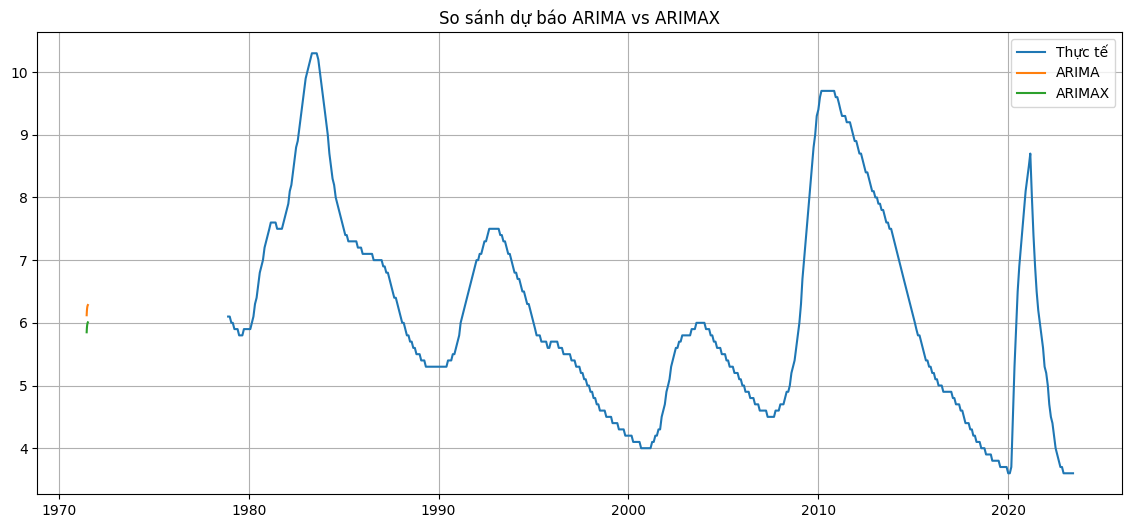

In [11]:
# Dự báo 24 tháng tiếp theo
forecast_arima = result_arima.get_forecast(steps=24)
forecast_arimax = result_arimax.get_forecast(steps=24, exog=[[1]]*24)

# Trực quan
plt.figure(figsize=(14,6))
plt.plot(df_model['date'], df_model['all'], label='Thực tế')
plt.plot(forecast_arima.predicted_mean.index, forecast_arima.predicted_mean, label='ARIMA')
plt.plot(forecast_arimax.predicted_mean.index, forecast_arimax.predicted_mean, label='ARIMAX')
plt.legend()
plt.title("So sánh dự báo ARIMA vs ARIMAX")
plt.grid(True)
plt.show()
